## 1.  Importing Required Libraries

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from skimage.feature import hog
from tqdm.notebook import tqdm
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist
import os
import warnings
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os


In [4]:
def read_img(path,gray=True,rgb=False):
    if gray:
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(path)
    img=cv2.resize(img,(128,128),interpolation=cv2.INTER_AREA)
    if rgb:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def show_img(img,gray=False):
    if gray:
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.show()

In [5]:
folder_name="data"
folder_name_data=["train"]

In [6]:
import os

# Đường dẫn đến thư mục bạn muốn chuyển đến
new_directory = "/kaggle/input/5-famous-people-face-recognition"

# Chuyển đến thư mục mới
os.chdir(new_directory)

# Kiểm tra xem đã chuyển đến thư mục mới thành công chưa
current_directory = os.getcwd()
print("Đã chuyển đến thư mục:", current_directory)


Đã chuyển đến thư mục: /kaggle/input/5-famous-people-face-recognition


In [7]:
dict_count={}
file_anh_train=[]
file_anh_test=[]
for fnd in folder_name_data:
    list_file = os.listdir(folder_name +"/"+ fnd)
    for i in list_file:
        list_file_i=len(os.listdir(folder_name +"/"+ fnd+"/"+i))
        if fnd == "train":
            for j in os.listdir(folder_name +"/"+ fnd+"/"+i):
                file_anh_train.append(folder_name +"/"+ fnd+"/"+i+"/"+j)
        else:
            for j in os.listdir(folder_name +"/"+ fnd+"/"+i):
                file_anh_test.append(folder_name +"/"+ fnd+"/"+i+"/"+j)
        if i in dict_count:
            dict_count[i]+=list_file_i
        else:
            dict_count[i]=list_file_i

In [8]:
dict_count.values()

dict_values([600, 600, 600, 600, 600])

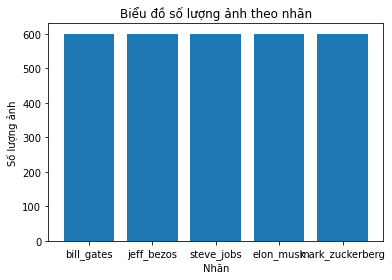

In [9]:
plt.bar(dict_count.keys(), dict_count.values())
plt.xlabel('Nhãn')
plt.ylabel('Số lượng ảnh')
plt.title('Biểu đồ số lượng ảnh theo nhãn')
plt.show()

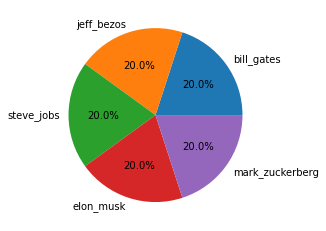

In [10]:
plt.pie(dict_count.values(),labels=dict_count.keys(),autopct='%1.1f%%')
plt.show()

In [11]:
file_img_path=file_anh_train+file_anh_test
file_img_path[:5]

['data/train/bill_gates/606be033-b7df-481e-81da-d5803b2831e8.jpg',
 'data/train/bill_gates/3b3f93a8-3c80-4760-b242-6037407a152d.jpg',
 'data/train/bill_gates/54f47f9e-67e7-4d2f-8ed0-a362f9d0ec76.jpg',
 'data/train/bill_gates/405cead0-a483-4c8b-a48e-f8ad4700a260.jpg',
 'data/train/bill_gates/2460143f-fce7-4d04-b2c2-50e02bef7fde.jpg']

In [12]:
from sklearn.model_selection import train_test_split
import glob

In [13]:
train,test=train_test_split(file_img_path,test_size=0.2,random_state=42)

In [14]:
len(train)

2400

In [15]:
len(test)

600

In [28]:
la={
    'bill_gates': 0,
    'elon_musk': 1,
    'jeff_bezos': 2,
    'mark_zuckerberg': 3,
    'steve_jobs': 4
}

In [29]:
label_name = os.path.basename(os.path.dirname(train[0]))
label_index = la.get(label_name, -1)

In [18]:
label_name

'jeff_bezos'

In [22]:
label_index

2

In [30]:
def extract_features_hog(dataset, labels = la):
    hog_imgs = []
    features_imgs = []
    labels_hog = []
    path_imgs = []
    for i in tqdm(dataset, desc='Trích xuất đặc trưng HOG'):
        label_name = os.path.basename(os.path.dirname(i))
        label_index = la.get(label_name, -1)
        labels_hog.append(label_index)
        
        image = cv2.imread(i)
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cell_size = (8, 8) 
        block_size = (2, 2)  
        nbins = 9  

        features, hog_image = hog(gray, orientations=nbins, pixels_per_cell=cell_size, cells_per_block=block_size, visualize=True, block_norm='L2')
        hog_imgs.append(hog_image)
        features_imgs.append(features)
        path_imgs.append(i)
    return hog_imgs, features_imgs, labels_hog, path_imgs


In [31]:
import threading

def extract_features_hog_thread(dataset, result):
    hog_imgs, features_imgs, labels_hog, path_imgs = extract_features_hog(dataset)
    result.append((hog_imgs, features_imgs, labels_hog, path_imgs))

def run_threading_extract_hog(dataset, num_thread=12):
    datasets = np.array_split(dataset, num_thread)
    threads = []
    results = []
    
    for i in range(num_thread):
        thread = threading.Thread(target=extract_features_hog_thread, args=(datasets[i], results))
        thread.start()
        threads.append(thread)
    
    for thread in threads:
        thread.join()

    hog_imgs = []
    features_imgs = []
    labels_hog = []
    path_imgs = []
    
    for result in results:
        hog_imgs.extend(result[0])
        features_imgs.extend(result[1])
        labels_hog.extend(result[2])
        path_imgs.extend(result[3])
    
    return hog_imgs, features_imgs, labels_hog, path_imgs


In [32]:
X_train_hog, X_train_features, y_train_labels,train_path_imgs = run_threading_extract_hog(train)

In [33]:
X_test_hog, X_test_features, y_test_labels,test_path_imgs = run_threading_extract_hog(test)

In [34]:
# Kiểm tra các giá trị trong y_train_labels
print("Giá trị trong y_train_labels:", set(y_train_labels))

# Kiểm tra các khóa trong từ điển la
print("Các khóa trong từ điển la:", la.keys())


Giá trị trong y_train_labels: {0, 1, 2, 3, 4}
Các khóa trong từ điển la: dict_keys(['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs'])


In [49]:
def get_key_from_value(dictionary, target_value):
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None  # Trả về None nếu không tìm thấy

# Sử dụng hàm để lấy khóa từ giá trị trong từ điển
key = get_key_from_value(la, 1)

In [50]:
key

'elon_musk'

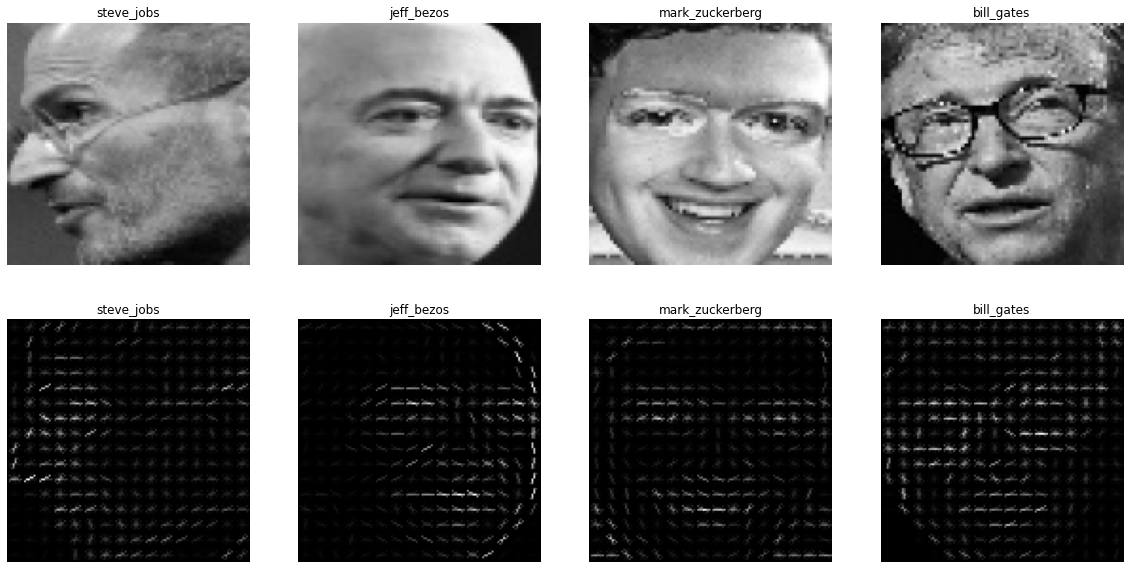

In [53]:
column = 4
random_choice = random.sample(range(len(X_train_hog)), column)
fig, axs = plt.subplots(2, column, figsize=(20, 10))
for i in range(column):
    img = read_img(train_path_imgs[random_choice[i]])
    axs[0,i].imshow(img,cmap='gray')
    axs[0,i].set_title(get_key_from_value(la,y_train_labels[random_choice[i]]))
    axs[0,i].axis('off')
    axs[1,i].imshow(X_train_hog[random_choice[i]],cmap='gray')
    axs[1,i].set_title(get_key_from_value(la,y_train_labels[random_choice[i]]))
    axs[1,i].axis('off')
plt.show()

In [59]:
from sklearn import svm
from tqdm import tqdm

# Khởi tạo mô hình
model_hog = svm.SVC()
num_epochs =1

# Huấn luyện mô hình với tqdm
for _ in tqdm(range(num_epochs), desc="Training"):
    model_hog.fit(X_train_features, y_train_labels)


Training: 100%|██████████| 1/1 [01:12<00:00, 72.14s/it]


In [60]:
y_predictions = model_hog.predict(X_test_features)

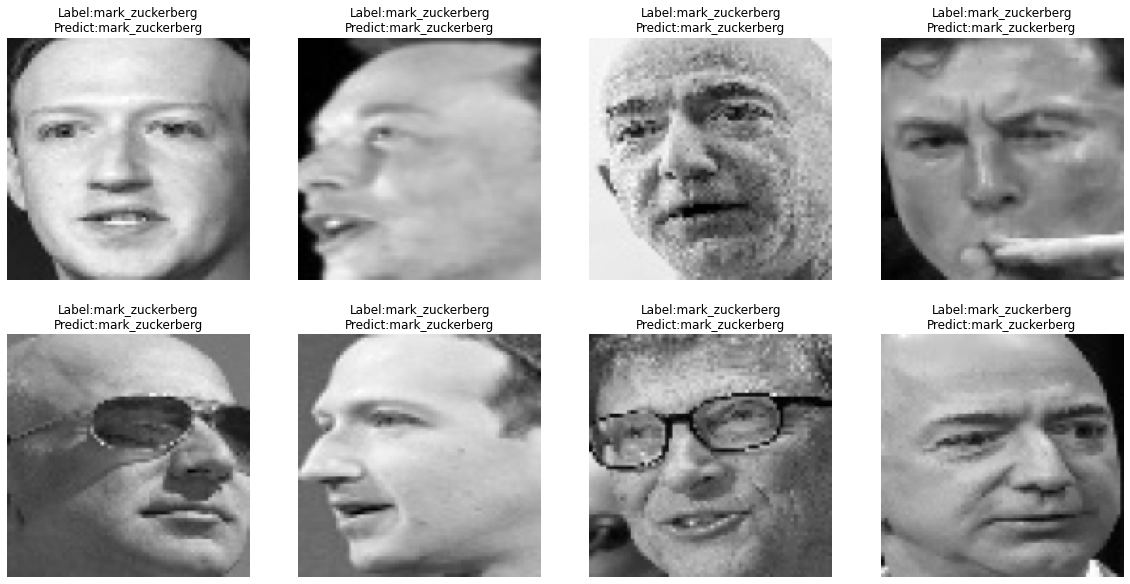

In [62]:
column = 4
row = 2
fig, axs = plt.subplots(2, column, figsize=(20, 10))
for i in range(row):
    random_choice = random.sample(range(len(X_test_hog)), column)
    for j in range(column):
        img = read_img(test_path_imgs[random_choice[j]])
        axs[i,j].imshow(img,cmap='gray')
        axs[i,j].set_title("Label:"+get_key_from_value(la,y_test_labels[random_choice[i]])+"\nPredict:"+get_key_from_value(la,y_predictions[random_choice[i]]))
        axs[i,j].axis('off')
plt.show()

In [63]:
print(classification_report(y_test_labels, y_predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       141
           1       0.90      0.93      0.91       111
           2       0.95      0.93      0.94       113
           3       0.93      0.93      0.93       113
           4       0.98      0.98      0.98       122

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

